In [215]:
import Pkg
Pkg.add("Formatting")
using DataFrames, CSV
#using JLD
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots
using Distributions
using Graphs, LightGraphs, MetaGraphs, GraphPlot, GraphRecipes, SimpleWeightedGraphs
using Geodesy
using Formatting

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [59287772] + Formatting v0.4.2
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [238]:
#import dataset
schedule_2023 = CSV.read("F1_baseline.csv", DataFrame) #actual schedule for 2023
schedule_2023 = permutedims(schedule_2023) #transpose the dataset
delete!(schedule_2023, 25) #this row is the break between first and second half of the season
show(schedule_2023, allcols=true, allrows=true)

39×2 DataFrame
 Row │ x1   x2  
     │ Any  Any 
─────┼──────────
   1 │ i    j
   2 │ 1    3
   3 │ 3    1
   4 │ 1    23
   5 │ 23   1
   6 │ 1    2
   7 │ 2    1
   8 │ 1    12
   9 │ 12   1
  10 │ 1    22
  11 │ 22   25
  12 │ 25   1
  13 │ 1    14
  14 │ 14   5
  15 │ 5    4
  16 │ 4    1
  17 │ 1    6
  18 │ 6    1
  19 │ 1    21
  20 │ 21   7
  21 │ 7    1
  22 │ 1    8
  23 │ 8    9
  24 │ 9    1
  25 │ 1    18
  26 │ 18   10
  27 │ 10   1
  28 │ 1    11
  29 │ 11   15
  30 │ 15   1
  31 │ 1    24
  32 │ 24   1
  33 │ 1    20
  34 │ 20   17
  35 │ 17   13
  36 │ 13   1
  37 │ 1    19
  38 │ 19   16
  39 │ 16   1

In [528]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(25)
    for i in 2:39
        Graphs.add_edge!(G, df[i, :x1], df[i, :x2])
    end
    return G
end

visualize_loops (generic function with 1 method)

In [529]:
G = visualize_loops(schedule_2023)

{25, 38} directed simple Int64 graph

In [530]:
all_df = CSV.read("circuits.csv", DataFrame)
races_circuitref = ["bahrain", "jeddah", "albert_park", "shanghai", "baku", "miami", "imola", "monaco", "catalunya", "villeneuve", "red_bull_ring", "silverstone", "hungaroring", "spa", "zandvoort", "monza", "marina_bay", "suzuka", "losail", "americas", "rodriguez", "interlagos", "las_vegas", "yas_marina"]
df = all_df[in(races_circuitref).(all_df.circuitRef), :] #only keep rows for the races that we care about, i.e. 2024 schedule

circuitRefs = df[1:24, :circuitRef] #get all races from initial df
circuits = ["HOME"; circuitRefs]; # create vector with string "home" and add circuitRefs to it
circuits

25-element Vector{String}:
 "HOME"
 "albert_park"
 "bahrain"
 "catalunya"
 "monaco"
 "villeneuve"
 "silverstone"
 "hungaroring"
 "spa"
 "monza"
 "marina_bay"
 "shanghai"
 "interlagos"
 "imola"
 "suzuka"
 "yas_marina"
 "rodriguez"
 "zandvoort"
 "las_vegas"
 "americas"
 "red_bull_ring"
 "baku"
 "jeddah"
 "losail"
 "miami"

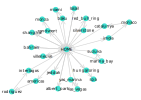

In [532]:
gplot(G, nodelabel=circuits)

## Calculate baseline cost

In [199]:
#Declare an empty 25 x 25 matrix
schedule_2023_matrix = zeros(25, 25)
for i in 2:39
    schedule_2023_matrix[schedule_2023[i, :x1], schedule_2023[i, :x2]] = 1
end

schedule_2023_matrix

25×25 Matrix{Float64}:
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [202]:
#Import weighted distance matrix 
distances = CSV.read("distance_matrix.csv", DataFrame);
distances_matrix = Matrix(distances)

25×25 Matrix{Float64}:
     0.0   10361.5    12339.2    12232.2    …  10296.0    11982.6   12281.8
 10361.5       0.0     4611.4     4255.09        112.126  10429.7    5233.95
 12339.2    4611.4        0.0      486.382      4715.71    7118.05   1583.08
 12232.2    4255.09     486.382      0.0        4360.07    7393.93   1423.35
 12317.0    9204.84    5699.13    5905.26       9276.43    2238.05   4951.13
 12365.8    5024.18    1192.61    1118.79   …   5123.11    6701.91    986.96
 11956.8    3581.74    1497.65    1013.61       3684.54    7956.92   1886.31
 12254.6    4542.94    1025.19     752.735      4643.79    7134.44   1180.99
 12193.3    4169.36     722.596    255.8        4273.77    7454.55   1356.35
  5823.41   6071.37    9607.14    9305.1        5976.23   12389.9    9731.55
  7518.32   6497.96    8867.44    8516.75   …   6443.2    11007.8    8612.67
 10912.9   10191.0     8123.2     8481.15      10233.3     6285.86   8470.43
 12133.8    3956.27     829.604    350.851      4061.6

In [218]:
#Multiply both matrices and sum 
total_distance_2023 = sum(schedule_2023_matrix .* distances_matrix)
println("The total distance for the actual 2023 schedule is: ", format(round(total_distance_2023, digits=2), commas=true), " km")

The total distance for the actual 2023 schedule is: 351,964.87 km


# Travelling Salesman Problem for Logistics

In [533]:
#Import actual logistics DataFrame
logistics_2023 = CSV.read("Logistics_Actual_2023.csv", DataFrame);
logistics_2023

Row,i,j
,Int64,Int64
1,1,3
2,3,23
3,23,2
4,2,12
5,12,22
6,22,25
7,25,14
8,14,5
9,5,4


In [534]:
function visualize_loops(df)
    G = Graphs.SimpleDiGraph(25)
    for i in 1:25
        Graphs.add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

visualize_loops (generic function with 1 method)

In [535]:
G = visualize_loops(logistics_2023)

{25, 25} directed simple Int64 graph

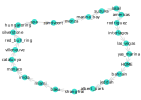

In [551]:
gplot(G, nodelabel=circuits)

In [553]:
#Declare an empty 25 x 25 matrix
logistics_2023_matrix = zeros(25, 25)
for i in 1:25
    logistics_2023_matrix[logistics_2023[i, :i], logistics_2023[i, :j]] = 1
end

logistics_2023_matrix

25×25 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [555]:
#Multiply both matrices and sum 
total_distance_logistics_2023 = sum(logistics_2023_matrix .* distances_matrix)
println("The total distance for the actual 2023 LOGISTICS schedule is: ", format(round(total_distance_logistics_2023, digits=2), commas=true), " km")

The total distance for the actual 2023 LOGISTICS schedule is: 146,070.1 km


In [556]:
#Total distance including logistics_2023
total_distance_2023_both=total_distance_2023 + total_distance_logistics_2023
println("The total distance for the actual 2023 schedule including logistics is: ", format(round(total_distance_2023_both, digits=2), commas=true), " km")

The total distance for the actual 2023 schedule including logistics is: 498,034.97 km


In [ ]:
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 1)
set_optimizer_attribute(model, "Threads", 20)
set_optimizer_attribute(model, "MIPGap", 0.01)

# variables
@variable(model, x[i in V, j in V], Bin)

# constraints
# each circuit can only be visited once
@constraint(model, only_one_in[j in V_0], sum(x[i, j] for i in V) == 1)
@constraint(model, only_one_out[i in V_0], sum(x[i, j] for j in V) == 1) 

# we cannot go from a circuit to itself
@constraint(model, no_self_connect[i in V], x[i, i] == 0)

#Connections formed in the firs optimization problem VRP
@constraint(model, x[a,b] == 1) #First part of a triple header
@constraint(model, x[b,c] == 1) #Second part of a triple header
@constraint(model, x[d,e] == 1) #One double header
@constraint(model, x[f,g] == 1) #Another double header

# we must start and end at home and the number of loops away from home is subloops
@constraint(model, K_petals_in, sum(x[i, 1] for i in V_0) == 1)
@constraint(model, K_petals_out, sum(x[1, j] for j in V_0) == 1)

# no subloops that do not connect to home
for S in all_S
    @constraint(model, sum(x[i, j] for i in S, j in S) <= length(S) - 1)
end

#objective
@objective(model, Min, sum(sum(x[i, j] * distance_matrix[i, j] for i in V) for j in V));